# pyburst demonstration

In [1]:
import math
import numpy
import matplotlib.pyplot as plt
import pyburst as pb
import pyburst.detectors, pyburst.cbc, pyburst.timefreq, pyburst.skymaps
import gwpy
import healpy
from gwpy.timeseries import TimeSeries

In [2]:
plt.rcParams['figure.figsize'] = [12.0, 6.0]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['figure.titlesize'] = 'medium'

## Define detector network

In [3]:
detectors = ['H1', 'L1', 'V1']
network = [pb.detectors.Detector(d) for d in detectors]

## Seek data from local files

In [4]:
gps = 1187008887
offset = +5
segment = (int(gps + offset)-5, int(gps + offset)+5)
print(segment)

datafolder = '../../HLV-data'
datafiles = ['H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5', \
            'L-L1_LOSC_CLN_4_V1-1187007040-2048.hdf5', \
            'V-V1_LOSC_CLN_4_V1-1187007040-2048.hdf5']
channelname = 'strain'

data = []
for f,d in zip(datafiles, network):
    data.append(TimeSeries.read('/'.join((datafolder,f)), start=segment[0], end=segment[1], format='hdf5.losc'))

(1187008887, 1187008897)


In [5]:
sampling_rates = [1./stream.dt.value for stream in data]
sampling_rate = sampling_rates[0] if all(rate == sampling_rates[0] for rate in sampling_rates) else None
print("Sampling rate is {} Hz".format(sampling_rate))

Sampling rate is 4096.0 Hz


In [6]:
# Define injection time and sky position
time = sum(segment)/len(segment)
ra = -90.
dec = +45.

# Define compact binary (component masses and distance)
mass1 = 36 # Msun 
mass2 = 29 # Msun 
distance = 100 # Mpc

# Define its geometrical parameters (sky position and other angles)
iota = 0
psi = 0
phi_ref = 0

# Define waveform model
approximant = "SEOBNRv3"
amplitude_order = 0
phase_order = -1

# Define frequency range
freq_min = 20 # Hz
freq_max = sampling_rate/2

# Create binary            
binary = pb.cbc.Binary(mass1, mass2, distance, pb.cbc.ZERO, pb.cbc.ZERO, 0.0, 0.0, 0, 0, iota, psi)
        
# Create waveform model
model = pb.cbc.Template(approximant, amplitude_order, phase_order, sampling_rate, \
                     freq_min, freq_max, 0.0, phi_ref)

# Generate GW polarizations for that binary using that model
hplus, hcross = model.time_domain(binary)

## Inject signal in observations

In [7]:
hoft = []
for detector, obs in zip(network, data):
        
        # Project polarizations onto detector frame 
        signal = detector.project_strain(hplus, hcross, time, \
                                         ra, dec, psi)
        signal.t0 = time + signal.epoch.value
        
        # XXX Hack to force unit agreement -- 'strain' is incompatible with lal.DimensionlessUnit XXX
        #signal._unit = lal.DimensionlessUnit
        #obs._unit = lal.DimensionlessUnit
        
        # XXX Hack -- noise free observations !! XXX
        obs_ = TimeSeries(numpy.zeros(numpy.shape(obs.value)), sample_rate=obs.sample_rate, \
                                 t0=obs.t0, unit=signal._unit)
        #obs_.unit = lal.DimensionlessUnit
        
        # Inject waveform
        hoft.append(obs_.inject(signal))

## Define sky grid

In [8]:
NSIDE = 16
array = numpy.zeros(healpy.nside2npix(NSIDE))
sky = pb.skymaps.Skymap(NSIDE, 'geographic', array, order='nested')

## Compute antenna pattern over the sky grid

In [9]:
antenna_patterns= []
for p in sky.grid.healpix_to_skycoord(range(sky.grid.npix)):
    antenna_patterns.append([d.antenna_pattern(math.radians(p.ra.value), math.radians(p.dec.value), 0, ref_time=None) \
                             for d in network])
    
antenna_patterns = numpy.array(antenna_patterns)

## Compute propagation delays over the sky grid

In [10]:
delays = []
for p in sky.grid.healpix_to_skycoord(range(sky.grid.npix)):
    delays.append([d.time_delay_from_earth_center(math.radians(p.ra.value), math.radians(p.dec.value), \
                                                  ref_time=None) for d in network])
    
delays = numpy.array(delays)

## Time frequency transforms

In [11]:
gabor = pb.timefreq.TimeFreqTransform("dgtreal", "hanning", 64, 512)
tfmaps = list(map(gabor.forward, hoft))

### Noise free observations -- here!!!

In [12]:
tfmaps_ = list(map(gabor.forward, data))

## Background spectrum estimate

### Noise free observations -- here!!!

In [13]:
# XXX Use robust pyCBC-like median/mean estimate XXX
# XXX HACK!! forced noise only XXX
strip_edge_size = 5
asds = numpy.array([numpy.linalg.norm(tfmap.trim_edges(strip_edge_size).data, axis=1) for tfmap in tfmaps_])
freqs = numpy.array([tfmap.freqs(sampling_rate) for tfmap in tfmaps_])

## Whitening

In [14]:
lowf_cutoff = 25 # Hz
zero_edge_size = 5
whitened_tfmaps = numpy.array([tfmap.trim_edges(zero_edge_size,0).highpass(lowf_cutoff, sampling_rate).data \
                            / numpy.reshape(asd, (asd.size,1)) \
                            for tfmap, asd in zip(tfmaps, asds)])

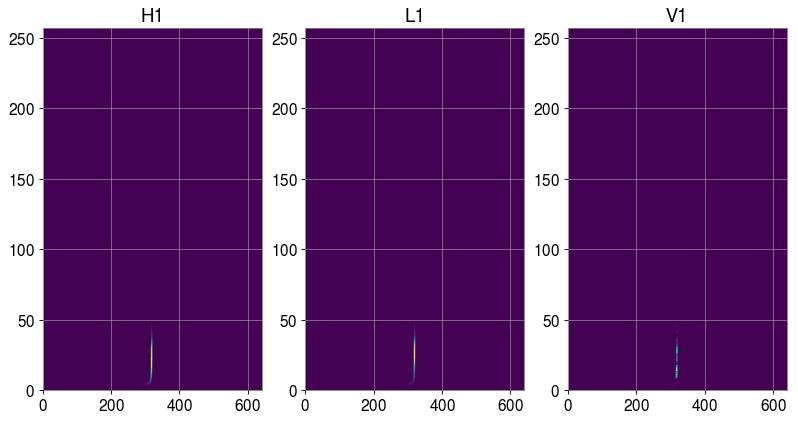

In [15]:
fig, axes = plt.subplots(1, len(network))
for ax, d, m in zip(axes, network, whitened_tfmaps):
    ax.pcolormesh(numpy.abs(m))
    ax.set_title(d)
plt.show()

## Main loop -- least square inversion

### Compute mixing matrix at each frequencies
Note: this can be done only once for an entire segment

In [16]:
phases = numpy.exp(-2*numpy.pi*1j* numpy.einsum('ij,jk->ijk', delays, freqs))
mixing = numpy.einsum('ijk,ijl->iljk', antenna_patterns, phases)
mixing_whitened = numpy.einsum('ijk,jl,ijl->iljk', antenna_patterns, 1/asds, phases)
mixing_whitened_inverse = numpy.linalg.pinv(mixing_whitened)

## Pixel selection

In [17]:
# XXXX Use an ad-hoc mask for now XXXX
# This mask was draw by hand and represent the best result one you
# obtain with a clever pixel selection algorithm (to be designed)
# The mask should be applied to the tile [15:50,250:350]
mask = numpy.logical_not(plt.imread('../../HLV-data/mask-bbh.png')[:,:,0])
#idx_time = numpy.arange(290,340, dtype=numpy.intp)
idx_time = numpy.arange(294,344, dtype=numpy.intp)
idx_freq = numpy.arange(3,50, dtype=numpy.intp)
# idx_time = numpy.arange(250,350, dtype=numpy.intp)
# idx_freq = numpy.arange(15,50, dtype=numpy.intp)
idx = numpy.ix_(numpy.arange(3), idx_freq, idx_time)
reduced_tfmaps =  mask * whitened_tfmaps[idx]

In [18]:
reduced_tfmaps.shape

(3, 47, 50)

Il faut trouver ici un moyen de reduire le nombre de pixels tout en preservant l'axe frequentiel
pour pouvoir continuer a appliquer la matrice de melange. Garder les indices temporels en memoire afin
de pouvoir reconstruire le signal ensuite.

Faire la selection en se basant seulement sur l'energie incoherente est probablement trop optimiste -- Perte de l'information de coincidence --> multiplication des clusters qui viennent du bruit

## Apply pseudo inverse to observations
Note: this produces an estimate of the signal time-frequency map assuming all source directions in the skygrid.
To save time, this could be done **only** on selected/clusterized pixels (above a certain threshold)

In [19]:
signal_estimate_tfmaps = numpy.einsum('ijkl,ljm->ijmk', mixing_whitened_inverse[:,idx_freq, ...], reduced_tfmaps)
#signal_estimate_tfmaps = numpy.einsum('ijkl,ljm,jm->ijmk', mixing_whitened_inverse[:,idx_freq, ...], reduced_tfmaps, mask)
response_estimate_tfmaps = numpy.einsum('ijkl,ijml->ikjm', mixing_whitened[:,idx_freq, ...], signal_estimate_tfmaps)
estimation_error = numpy.linalg.norm(reduced_tfmaps[numpy.newaxis,:] \
                                    - response_estimate_tfmaps, \
                                         axis=(-2,-1)).sum(axis=-1)
skymap = sky.feed(estimation_error)

## Results and diagnosis plots

### Localization

In [20]:
injection_pt = pb.skymaps.Skypoint(numpy.radians(ra), numpy.radians(dec), \
                     'equatorial', 'injection')
print(injection_pt)

injection (equatorial): lon= -1.57079633 rad ( -90.00 deg) lat= +0.78539816 rad (  45.00 deg)


In [21]:
skymap_equatorial = skymap.transform_to('equatorial', time)
leastsquare_pt = skymap_equatorial.argmin('leastsquare')
print(leastsquare_pt)

leastsquare (val=0.93) (equatorial): lon= +0.54977871 rad (  31.50 deg) lat= +1.05477994 rad (  60.43 deg)


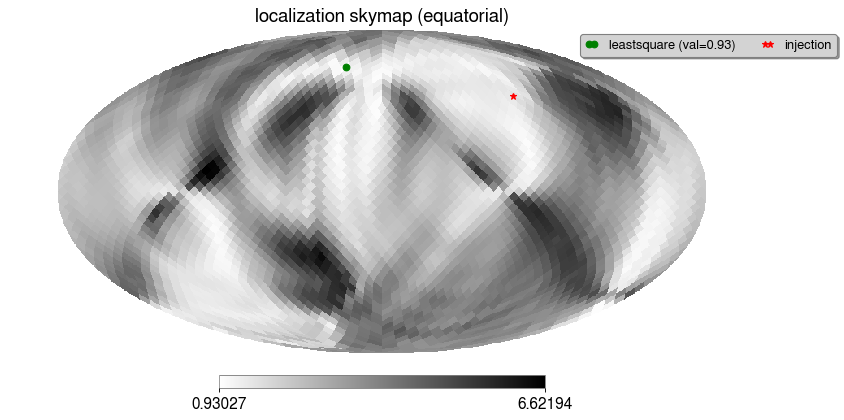

In [22]:
skymap_equatorial.display("localization skymap")
leastsquare_pt.display('o','g')
injection_pt.display('r','*')
plt.legend(loc='upper center', bbox_to_anchor=(1, 1),
            ncol=2, fancybox=True, shadow=True,\
            facecolor="lightgray", markerscale = 1)
plt.show()

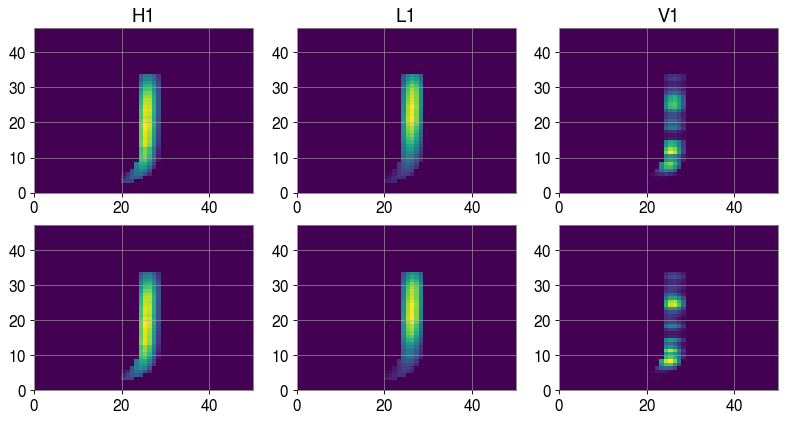

In [23]:
idx = estimation_error.argmin()
fig, axes = plt.subplots(2, len(network))
for n, d in enumerate(network):
    axes[0,n].pcolormesh(numpy.abs(reduced_tfmaps[n,...]))
    axes[0,n].set_title(d)
    axes[1,n].pcolormesh(numpy.abs(response_estimate_tfmaps[idx,n,...]))
plt.show()

plot of polarizations here

## Ideas about pixel selection

## Tests with skymaps